In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os

# Ruta al directorio con las imágenes
directorio_imagenes = '/content/drive/My Drive/Proyecto de Grado G/ProcessedImages_Disc_Exp2'

imagenes_info = []
for filename in os.listdir(directorio_imagenes):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        base = filename.split('_')[0]
        id_paciente = base[3:-2]  # Extrae correctamente el ID del paciente
        tipo_ojo = base[-2:]
        full_path = os.path.join(directorio_imagenes, filename)
        imagenes_info.append({'filename': full_path, 'id': id_paciente, 'eye': tipo_ojo})

imagenes_df = pd.DataFrame(imagenes_info)

# Cargar y preparar los datos clínicos
data_od = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_od.xlsx')
data_os = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_os.xlsx')

data_od['id'] = data_od['Unnamed: 0'].str.replace('#', '').astype(str)
data_os['id'] = data_os['Unnamed: 0'].str.replace('#', '').astype(str)

data_od['eye'] = 'OD'
data_os['eye'] = 'OS'

data_clinica = pd.concat([data_od[['id', 'eye', 'Diagnosis']], data_os[['id', 'eye', 'Diagnosis']]])

full_df = pd.merge(imagenes_df, data_clinica, on=['id', 'eye'], how='left')
full_df = full_df[full_df['Diagnosis'] != 2]  # Asume que quieres excluir los diagnósticos '2'

# Ahora necesitamos preparar los datos para un split estratificado
# Primero, determina la "etiqueta" dominante para cada paciente
dominant_diagnosis = full_df.groupby('id')['Diagnosis'].agg(lambda x: x.mode()[0])

# Crea el dataframe para el split estratificado
patient_df = pd.DataFrame(dominant_diagnosis).reset_index()

# Stratified split en los pacientes
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_patients, test_patients = next(splitter.split(patient_df, patient_df['Diagnosis']))

# Obtén los ID de pacientes para cada conjunto
train_ids = patient_df.iloc[train_patients]['id']
test_ids = patient_df.iloc[test_patients]['id']

# Finalmente, selecciona las filas correspondientes en full_df
train_df = full_df[full_df['id'].isin(train_ids)]
test_df = full_df[full_df['id'].isin(test_ids)]

print("Train DataFrame:")
print(train_df[['filename', 'id', 'eye', 'Diagnosis']].head())

print("\nTest DataFrame:")
print(test_df[['filename', 'id', 'eye', 'Diagnosis']].head())

Train DataFrame:
                                             filename   id eye Diagnosis
2   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OD         1
3   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OS         1
4   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OD         1
5   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OS         1
14  /content/drive/My Drive/Proyecto de Grado G/Pr...  010  OD         1

Test DataFrame:
                                             filename   id eye Diagnosis
20  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OD         1
21  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OS         1
32  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OD         1
33  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OS         1
42  /content/drive/My Drive/Proyecto de Grado G/Pr...  028  OD         0


In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score

In [4]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular los pesos de clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Diagnosis']),
    y=train_df['Diagnosis'].astype(int)
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.6320754716981132, 1: 2.392857142857143}


In [5]:
# Configuración del modelo
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_b_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [7]:
# Cambiar el tipo de 'Diagnosis' a string usando .loc para evitar SettingWithCopyWarning
train_df.loc[:, 'Diagnosis'] = train_df['Diagnosis'].astype(str)
test_df.loc[:, 'Diagnosis'] = test_df['Diagnosis'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

train_b_generator = train_b_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 268 validated image filenames belonging to 2 classes.
Found 67 validated image filenames belonging to 2 classes.
Found 84 validated image filenames belonging to 2 classes.
Found 335 validated image filenames belonging to 2 classes.


In [8]:
# Calentamiento del modelo con pesos de clase
checkpoint_path = "best_model_warmup.keras"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", mode='min', verbose=1)

In [9]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[checkpoint],
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.8397
Epoch 1: val_loss improved from inf to 3.00940, saving model to best_model_warmup.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - loss: 0.8260 - val_loss: 3.0094
Epoch 2/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.7203
Epoch 2: val_loss improved from 3.00940 to 0.74425, saving model to best_model_warmup.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - loss: 0.6880 - val_loss: 0.7443
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.4260
Epoch 3: val_loss did not improve from 0.74425
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - loss: 0.4270 - val_loss: 1.0020
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.3278
Epoch 4: val_loss did not improve from 0.74425
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - loss: 0.3307 - val_loss: 0.8859
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.3475
Epoch 5: val_loss did not improve from 0.74425
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - loss: 0.3519 - val_loss: 1.0351
Epoc

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.load_weights("best_model_warmup.keras")

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy')

# Entrenar el modelo durante el fine-tuning
checkpoint_finetune_path = "best_model_finetune.keras"
checkpoint_finetune = ModelCheckpoint(
    checkpoint_finetune_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Fine-tuning del modelo
history_finetune = model.fit(
    train_generator,
    epochs=200,
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[checkpoint_finetune, early_stopping],
)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 0.8567 
Epoch 1: val_loss improved from inf to 0.72459, saving model to best_model_finetune.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 277s 14s/step - loss: 0.8551 - val_loss: 0.7246
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.8368
Epoch 2: val_loss did not improve from 0.72459
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - loss: 0.8374 - val_loss: 0.7280
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.8161
Epoch 3: val_loss did not improve from 0.72459
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - loss: 0.8165 - val_loss: 0.7512
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.7785
Epoch 4: val_loss did not improve from 0.72459
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - loss: 0.7797 - val_loss: 0.7784
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.8076
Epoch 5: val_loss did not improve from 0.72459
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - loss: 0.8045 - val_loss: 0.7650
Epoch 6/200
9/9 ━━━━━━━━━━

In [11]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

predictions_test = model.predict(test_generator, verbose=1)
y_test = test_generator.classes


thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    predicted_classes_test = (predictions_test >= threshold).astype(int)
    f1 = f1_score(y_test, predicted_classes_test)
    precision = precision_score(y_test, predicted_classes_test)
    recall = recall_score(y_test, predicted_classes_test)

    print(f'Threshold: {threshold:.2f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n')


    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Mejor threshold: {best_threshold} con F1 Score: {best_f1}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step
Threshold: 0.10
Precision: 0.2048, Recall: 1.0000, F1 Score: 0.3400

Threshold: 0.20
Precision: 0.1951, Recall: 0.9412, F1 Score: 0.3232

Threshold: 0.30
Precision: 0.2078, Recall: 0.9412, F1 Score: 0.3404

Threshold: 0.40
Precision: 0.2308, Recall: 0.8824, F1 Score: 0.3659

Threshold: 0.50
Precision: 0.2241, Recall: 0.7647, F1 Score: 0.3467

Threshold: 0.60
Precision: 0.1860, Recall: 0.4706, F1 Score: 0.2667

Threshold: 0.70
Precision: 0.2069, Recall: 0.3529, F1 Score: 0.2609

Threshold: 0.80
Precision: 0.5455, Recall: 0.3529, F1 Score: 0.4286

Threshold: 0.90
Precision: 0.5000, Recall: 0.0588, F1 Score: 0.1053

Mejor threshold: 0.8 con F1 Score: 0.42857142857142855


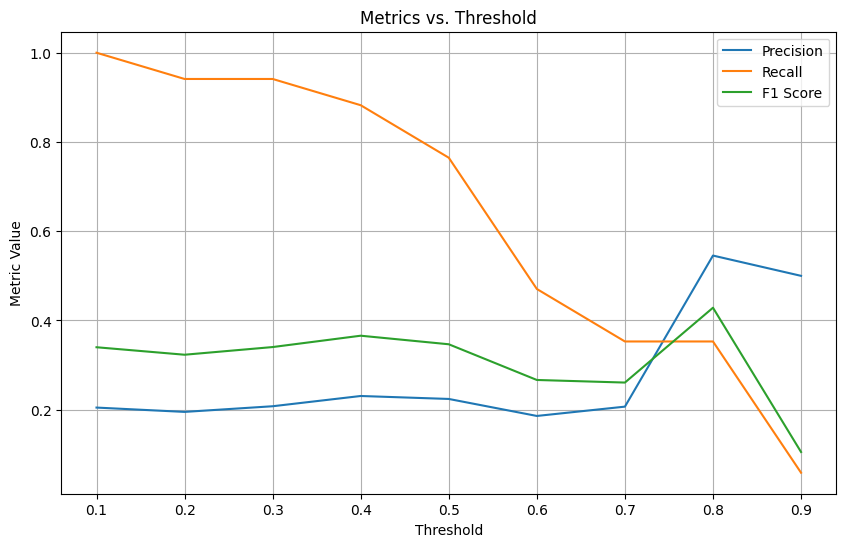

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Inicializar listas para almacenar las métricas
precisions = []
recalls = []
f1_scores = []

# Iterar sobre diferentes thresholds y calcular las métricas
for threshold in thresholds:
    predicted_classes_test = (predictions_test >= threshold).astype(int)
    precisions.append(precision_score(y_test, predicted_classes_test))
    recalls.append(recall_score(y_test, predicted_classes_test))
    f1_scores.append(f1_score(y_test, predicted_classes_test))

# Graficar las métricas en función de los thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Evaluar con el mejor threshold encontrado
predicted_classes_test = (predictions_test >= best_threshold).astype(int)
print("Test set classification report with custom threshold:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))

precision = precision_score(y_test, predicted_classes_test)
recall = recall_score(y_test, predicted_classes_test)

print("Precision (Test Set, Class 1) with custom threshold:", precision)
print("Recall (Test Set, Class 1) with custom threshold:", recall)

auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score:", auc_score_test)

Test set classification report with custom threshold:
              precision    recall  f1-score   support

     Clase 0       0.85      0.93      0.89        67
     Clase 1       0.55      0.35      0.43        17

    accuracy                           0.81        84
   macro avg       0.70      0.64      0.66        84
weighted avg       0.79      0.81      0.79        84

Precision (Test Set, Class 1) with custom threshold: 0.5454545454545454
Recall (Test Set, Class 1) with custom threshold: 0.35294117647058826
Test set AUC Score: 0.5908691834942933


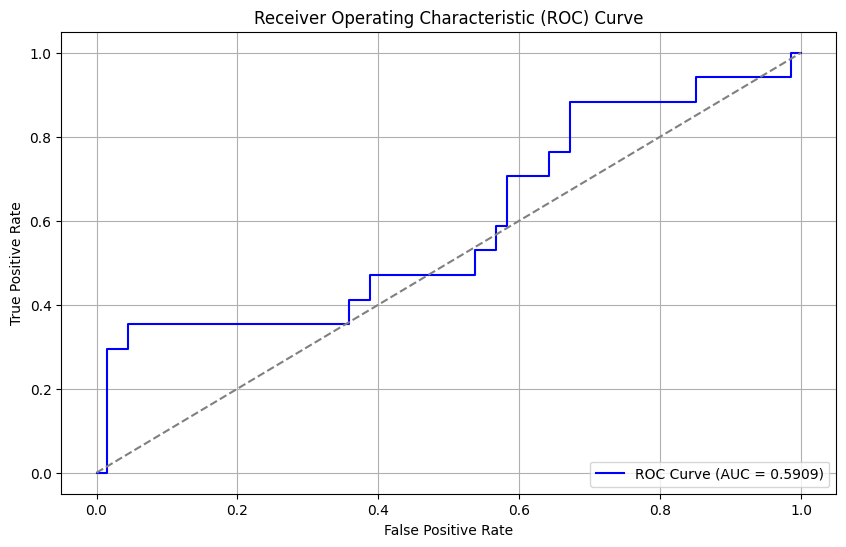

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, predictions_test)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#RESULTADOS ANTERIORES

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)

y_test = test_generator.classes

print("Test set classification report after warmup:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))
auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score after warmup:", auc_score_test)

predictions_train = model.predict(train_b_generator, steps=len(train_b_generator), verbose=1)
predicted_classes_train = np.round(predictions_train).astype(int)

y_train = train_b_generator.classes

print("Train set classification report after warmup:")
print(classification_report(y_train, predicted_classes_train, target_names=['Clase 0', 'Clase 1']))
auc_score_train = roc_auc_score(y_train, predictions_train)
print("Train set AUC Score after warmup:", auc_score_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step
Test set classification report after warmup:
              precision    recall  f1-score   support

     Clase 0       0.81      1.00      0.89        67
     Clase 1       1.00      0.06      0.11        17

    accuracy                           0.81        84
   macro avg       0.90      0.53      0.50        84
weighted avg       0.85      0.81      0.74        84

Test set AUC Score after warmup: 0.6128182616330113
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Train set classification report after warmup:
              precision    recall  f1-score   support

     Clase 0       0.82      1.00      0.90       265
     Clase 1       1.00      0.14      0.25        70

    accuracy                           0.82       335
   macro avg       0.91      0.57      0.57       335
weighted avg       0.85      0.82      0.76       335

Train set AUC Score after warmup: 0.8012938005390835


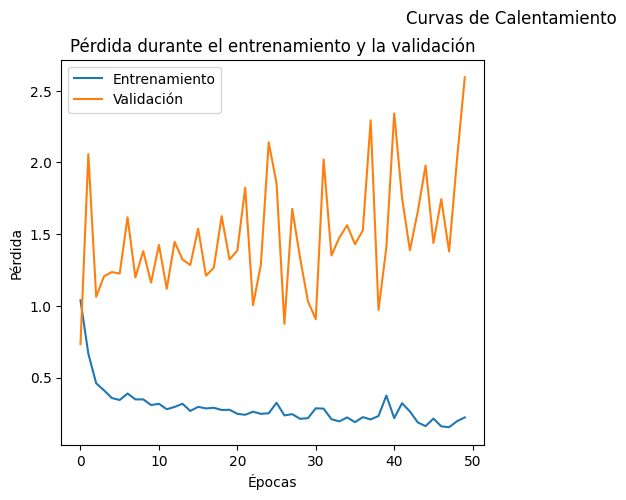

In [ ]:
def plot_training_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_training_curves(history, 'Curvas de Calentamiento')

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Evaluación del modelo en el conjunto de validación (test_generator) después del calentamiento
predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)

y_test = test_generator.classes

print("Test set classification report after fine-tuning:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))
auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score after fine-tuning:", auc_score_test)

predictions_train = model.predict(train_b_generator, steps=len(train_b_generator), verbose=1)
predicted_classes_train = np.round(predictions_train).astype(int)


y_train = train_b_generator.classes

print("Train set classification report after fine-tuning:")
print(classification_report(y_train, predicted_classes_train, target_names=['Clase 0', 'Clase 1']))
auc_score_train = roc_auc_score(y_train, predictions_train)
print("Train set AUC Score after fine-tuning:", auc_score_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
Test set classification report after fine-tuning:
              precision    recall  f1-score   support

     Clase 0       0.83      0.07      0.14        67
     Clase 1       0.21      0.94      0.34        17

    accuracy                           0.25        84
   macro avg       0.52      0.51      0.24        84
weighted avg       0.71      0.25      0.18        84

Test set AUC Score after fine-tuning: 0.4872695346795435
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 488ms/step
Train set classification report after fine-tuning:
              precision    recall  f1-score   support

     Clase 0       0.87      0.08      0.14       265
     Clase 1       0.21      0.96      0.35        70

    accuracy                           0.26       335
   macro avg       0.54      0.52      0.24       335
weighted avg       0.73      0.26      0.18       335

Train set AUC Score after fine-tuning: 0.6335309973045822


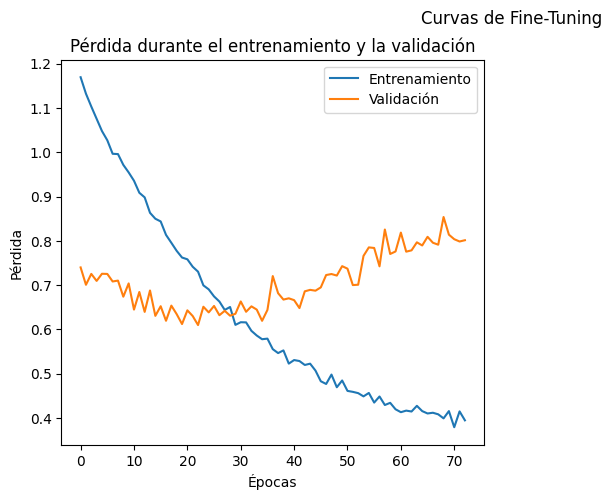

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.suptitle(title)
    plt.show()


plot_training_curves(history_finetune, 'Curvas de Fine-Tuning')


In [ ]:
from sklearn.metrics import precision_score, recall_score

predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)
y_test = test_generator.classes

precision = precision_score(y_test, predicted_classes_test, average='binary', pos_label=1)
recall = recall_score(y_test, predicted_classes_test, average='binary', pos_label=1)

print("Precision (Test Set, Class 1):", precision)
print("Recall (Test Set, Class 1):", recall)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Precision (Test Set, Class 1): 0.20512820512820512
Recall (Test Set, Class 1): 0.9411764705882353
